# Final project for Introduction to Quantum Computing (18-819F)

Project Description:
- Scalable and Accurate Generation of Hybrid MPC Protocols with Quantum Integer Programming

### Bootstrap

In [1]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


In [2]:
from qiskit_ibm_runtime import QiskitRuntimeService

# Initialize the account first.
service = QiskitRuntimeService()

### Available Backends

In [3]:
service.backends()

[<IBMBackend('ibmq_qasm_simulator')>,
 <IBMBackend('ibmq_lima')>,
 <IBMBackend('ibmq_belem')>,
 <IBMBackend('ibmq_quito')>,
 <IBMBackend('simulator_statevector')>,
 <IBMBackend('simulator_mps')>,
 <IBMBackend('simulator_extended_stabilizer')>,
 <IBMBackend('simulator_stabilizer')>,
 <IBMBackend('ibmq_manila')>,
 <IBMBackend('ibm_nairobi')>,
 <IBMBackend('ibm_oslo')>]

### Problem Setup

In [4]:
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.translators import from_docplex_mp

In [11]:
from docplex.mp.model import Model

mdl = Model("docplex model")
x = mdl.binary_var("x")
y = mdl.binary_var("y")
z = mdl.binary_var("z")

mdl.minimize(x + 2 * y + 3 * z)
mdl.add_constraint(x + y >= 1)
mdl.add_constraint(y + z >= 1)
print(mdl.export_as_lp_string())

\ This file has been generated by DOcplex
\ ENCODING=ISO-8859-1
\Problem name: docplex model

Minimize
 obj: x + 2 y + 3 z
Subject To
 c1: x + y >= 1
 c2: y + z >= 1

Bounds
 0 <= x <= 1
 0 <= y <= 1
 0 <= z <= 1

Binaries
 x y z
End



In [13]:
# load from a Docplex model
qp = from_docplex_mp(mdl)
print(type(qp))
print()
print(qp.prettyprint())

<class 'qiskit_optimization.problems.quadratic_program.QuadraticProgram'>

Problem name: docplex model

Minimize
  x + 2*y + 3*z

Subject to
  Linear constraints (2)
    x + y >= 1  'c0'
    y + z >= 1  'c1'

  Binary variables (3)
    x y z



#### Convert to Ising
- Inequalty to Equality
- Integer to Binary
- Linear Equality to Penalty

In [22]:
from qiskit_optimization.converters import InequalityToEquality
from qiskit_optimization.converters import IntegerToBinary
from qiskit_optimization.converters import LinearEqualityToPenalty

In [23]:
ineq2eq = InequalityToEquality()
int2bin = IntegerToBinary()
lineq2penalty = LinearEqualityToPenalty()

In [34]:
qp_eq = ineq2eq.convert(qp)
qp_eq_bin = int2bin.convert(qp_eq)
qubo = lineq2penalty.convert(qp_eq_bin)
print(qubo.prettyprint())
print(type(qubo))

Problem name: docplex model

Minimize
  7*c0@int_slack@0^2 + 7*c1@int_slack@0^2 - 14*x*c0@int_slack@0 + 7*x^2 + 14*x*y
  - 14*y*c0@int_slack@0 - 14*y*c1@int_slack@0 + 14*y^2 + 14*y*z
  - 14*z*c1@int_slack@0 + 7*z^2 + 14*c0@int_slack@0 + 14*c1@int_slack@0 - 13*x
  - 26*y - 11*z + 14

Subject to
  No constraints

  Binary variables (5)
    x y z c0@int_slack@0 c1@int_slack@0

<class 'qiskit_optimization.problems.quadratic_program.QuadraticProgram'>


To Ising

In [28]:
qubitOp, offset = qubo.to_ising()
print("Offset:", offset)
print("Ising Hamiltonian:")
print(str(qubitOp))

Offset: 17.0
Ising Hamiltonian:
3.0 * IIIIZ
+ 6.0 * IIIZI
+ 2.0 * IIZII
- 3.5 * IZIII
- 3.5 * ZIIII
+ 3.5 * IIIZZ
+ 3.5 * IIZZI
- 3.5 * IZIIZ
- 3.5 * IZIZI
- 3.5 * ZIIZI
- 3.5 * ZIZII


In [33]:
print(type(qubitOp))
print(type(offset))

<class 'qiskit.opflow.primitive_ops.pauli_sum_op.PauliSumOp'>
<class 'numpy.float64'>


### Classical Solver
- Dwave Annealing

In [29]:
!pip install dwave-ocean-sdk

     |████████████████████████████████| 686 kB 11.7 MB/s eta 0:00:01
     |████████████████████████████████| 111 kB 32.1 MB/s eta 0:00:01
     |████████████████████████████████| 2.3 MB 27.9 MB/s eta 0:00:01
     |████████████████████████████████| 103 kB 34.6 MB/s eta 0:00:01
     |████████████████████████████████| 97 kB 99 kB/s s eta 0:00:01
     |████████████████████████████████| 535 kB 32.9 MB/s eta 0:00:01
     |████████████████████████████████| 15.9 MB 32.1 MB/s eta 0:00:01
     |████████████████████████████████| 5.6 MB 31 kB/s s eta 0:00:01
     |████████████████████████████████| 725 kB 29.5 MB/s eta 0:00:01
     |████████████████████████████████| 74 kB 52 kB/s s eta 0:00:01
     |████████████████████████████████| 13.6 MB 25.7 MB/s eta 0:00:01                               | 317 kB 25.7 MB/s eta 0:00:01
     |████████████████████████████████| 44 kB 44 kB/s s eta 0:00:01
     |████████████████████████████████| 101 kB 259 kB/s eta 0:00:01
     |████████████████████████████████| 282 

In [66]:
import dimod
import neal

import matplotlib.pyplot as plt
import numpy as np
from scipy.special import gamma
import math
from collections import Counter
import pandas as pd
from itertools import chain
import time
import networkx as nx

In [67]:
print(type(qubo.objective.constant))
print(qubo.objective.constant)
print(qubo.objective.linear)
print(qubo.objective.linear.to_dict())
print(qubo.objective.quadratic)
print(qubo.objective.quadratic.to_dict())

linear = qubo.objective.linear.to_dict()
quadratic = qubo.objective.quadratic.to_dict()
constant = qubo.objective.constant
model = dimod.BinaryQuadraticModel(linear, quadratic, constant, dimod.Vartype.BINARY)

<class 'numpy.float64'>
14.0
14*c0@int_slack@0 + 14*c1@int_slack@0 - 13*x - 26*y - 11*z
{0: -13.0, 1: -26.0, 2: -11.0, 3: 14.0, 4: 14.0}
7*c0@int_slack@0^2 + 7*c1@int_slack@0^2 - 14*x*c0@int_slack@0 + 7*x^2 + 14*x*y - 14*y*c0@int_slack@0 - 14*y*c1@int_slack@0 + 14*y^2 + 14*y*z - 14*z*c1@int_slack@0 + 7*z^2
{(0, 0): 7.0, (0, 1): 14.0, (1, 1): 14.0, (1, 2): 14.0, (2, 2): 7.0, (0, 3): -14.0, (1, 3): -14.0, (3, 3): 7.0, (1, 4): -14.0, (2, 4): -14.0, (4, 4): 7.0}


In [68]:
simAnnSampler = neal.SimulatedAnnealingSampler()
simAnnSamples = simAnnSampler.sample(model, num_reads=1000)

In [69]:
def plot_enumerate(results, title=None):

    plt.figure()

    energies = [datum.energy for datum in results.data(
        ['energy'], sorted_by=None)]
    
    if results.vartype == 'Vartype.BINARY':
        samples = [''.join(c for c in str(datum.sample.values()).strip(
            ', ') if c.isdigit()) for datum in results.data(['sample'], sorted_by=None)]
        plt.xlabel('bitstring for solution')
    else:
        samples = np.arange(len(energies))
        plt.xlabel('solution')

    plt.bar(samples,energies)
    plt.xticks(rotation=90)
    plt.ylabel('Energy')
    plt.title(str(title))
    print("minimum energy:", min(energies))


def plot_energies(results, title=None):
    energies = results.data_vectors['energy']
    occurrences = results.data_vectors['num_occurrences']
    counts = Counter(energies)
    total = sum(occurrences)
    counts = {}
    for index, energy in enumerate(energies):
        if energy in counts.keys():
            counts[energy] += occurrences[index]
        else:
            counts[energy] = occurrences[index]
    for key in counts:
        counts[key] /= total
    df = pd.DataFrame.from_dict(counts, orient='index').sort_index()
    df.plot(kind='bar', legend=None)

    plt.xlabel('Energy')
    plt.ylabel('Probabilities')
    plt.title(str(title))
    plt.show()
    print("minimum energy:", min(energies))

minimum energy: 2.0


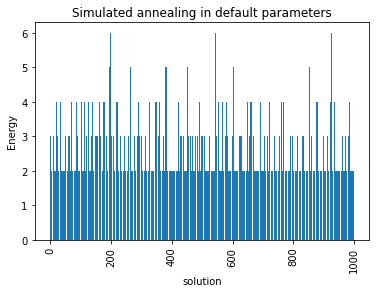

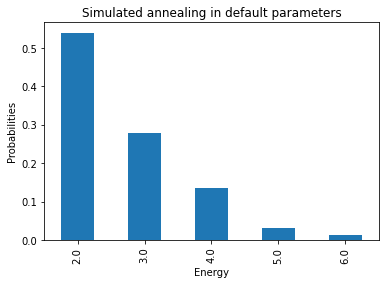

minimum energy: 2.0


In [70]:
plot_enumerate(simAnnSamples, title='Simulated annealing in default parameters')
plot_energies(simAnnSamples, title='Simulated annealing in default parameters')

In [82]:
print(simAnnSamples.aggregate().lowest())

   0  1  2  3  4 energy num_oc.
0  0  1  0  0  0    2.0     539
['BINARY', 1 rows, 539 samples, 5 variables]


### Quantum Solver

In [ ]:
!dwave setup -y

In [ ]:
!dwave ping

#### Quantum Annealing (Dwave)

QAOA(qiskit)